In [7]:
'''
    Setup the project
'''
# Make directory build if it doesn't exist
!mkdir -p build
!cd build && cmake .. -DCMAKE_BUILD_TYPE=Release && make

-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- IPO is supported
-- Configuring done
-- Generating done
-- Build files have been written to: /home/qasimkhawaja/PSRS/build
[ 20%] Built target engine
Scanning dependencies of target main
[ 40%] Building CXX object CMakeFiles/main.dir/app/main.cpp.o
[ 60%] Linking CXX executable main
[ 60%] Built target main
[100%] Built target unit_tests


In [7]:
# Install the python packages
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Running PSRS

In [8]:
def runExperiment(numElements, seed, useUniprocessor, numThreads=1):
    '''
        Runs the experiment and capture the results
        The command to run is `cd build && ./main {numThreads} {numElements} {seed} {useUniprocessor}`` which outputs
        ['p: numThreads n: numElements seed: seed useUniprocessor: useUniprocessor', 'time', 'Success'] where time is in nanoseconds
    '''
    sys.stdout.flush()
    result = !cd build && ./main {numThreads} {numElements} {seed} {useUniprocessor}
    assert len(result)==3 and result[2] == 'Success', 'Experiment failed'
    print(result)
    time = int(result[1])
    return time

In [20]:
def collectData(numElements, seed, useUniprocessor, numThreads=1, times=7):
    '''
        Collects the data by running the experiment multiple times
    '''
    data = []
    for i in range(times):
        time = runExperiment(numElements, seed+(i+1)*20, useUniprocessor, numThreads)
        data.append(time)
    return data

def plotData(data, title, xlabel, ylabel):
    '''
        Plots the data
    '''
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # calculate speedup
    speedup = [data[0][1]/x[1] for x in data]
    plt.plot([x[0] for x in data], speedup)
    plt.show()
    
def collectMultiprocessorData(numElements, seed, numThreads, lastRuns=5, times=7):
    '''
        Collects the data for the multiprocessor implementation
    '''
    assert lastRuns <= times, 'lastRuns should be less than or equal to times'
    data = []
    time_uniprocessor = collectData(numElements, seed, 1, times)
    data.append((1, sum(time_uniprocessor[-lastRuns:])/lastRuns))
    for i in range(2, numThreads):
        time = collectData(numElements, seed, 0, i, times)
        # take avg of last x runs
        avg = sum(time[-lastRuns:])/lastRuns
        data.append([i, avg])
    return data

['p: 1 n: 100000000 s: 63 useUniprocessor: 1', '25938852574', 'Success']
['p: 1 n: 100000000 s: 83 useUniprocessor: 1', '24527431375', 'Success']
['p: 1 n: 100000000 s: 103 useUniprocessor: 1', '24505613808', 'Success']
['p: 1 n: 100000000 s: 123 useUniprocessor: 1', '24521441452', 'Success']
['p: 1 n: 100000000 s: 143 useUniprocessor: 1', '24599013481', 'Success']
['p: 2 n: 100000000 s: 63 useUniprocessor: 0', '17137300710', 'Success']
['p: 2 n: 100000000 s: 83 useUniprocessor: 0', '16907527602', 'Success']
['p: 2 n: 100000000 s: 103 useUniprocessor: 0', '17118562933', 'Success']
['p: 2 n: 100000000 s: 123 useUniprocessor: 0', '16847197991', 'Success']
['p: 2 n: 100000000 s: 143 useUniprocessor: 0', '16907081442', 'Success']
['p: 3 n: 100000000 s: 63 useUniprocessor: 0', '12604718773', 'Success']
['p: 3 n: 100000000 s: 83 useUniprocessor: 0', '12550496670', 'Success']
['p: 3 n: 100000000 s: 103 useUniprocessor: 0', '12391796819', 'Success']
['p: 3 n: 100000000 s: 123 useUniprocessor: 

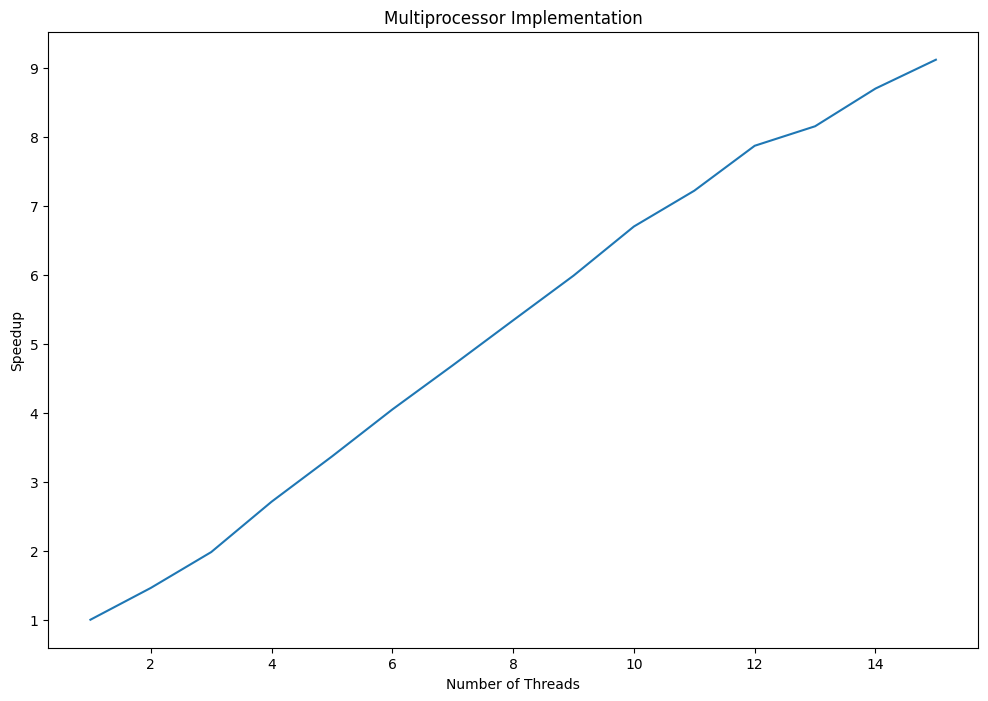

In [22]:
# Experiment 1
multiprocessorData = collectMultiprocessorData(100000000, 43, 16)
plotData(multiprocessorData, 'Multiprocessor Implementation', 'Number of Threads', 'Speedup')